In [131]:
import math
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.io import wavfile

/usr/local/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


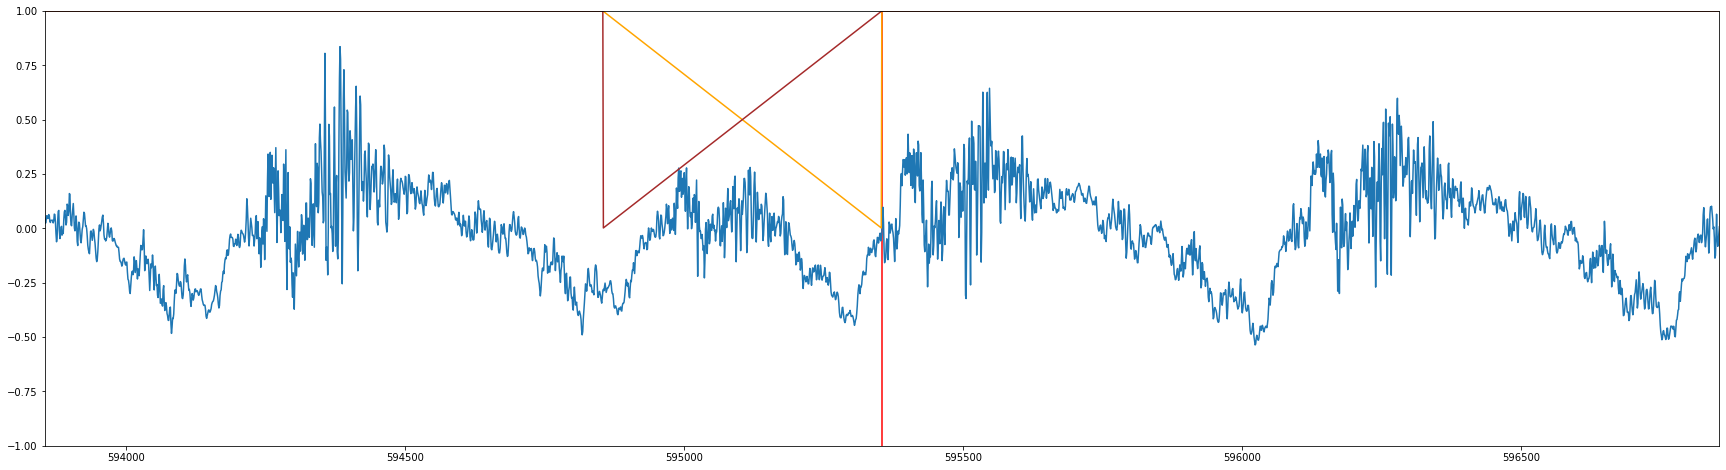

In [166]:


'''
sr = 44100
l = 4
f = 440
x = [math.sin((2 * math.pi * f /sr) * t) for t in range(0, l * sr)]
x = np.array(x)
'''

sr, x = wavfile.read('test_saw2.wav')
if x.shape[1] > 1:
    x = x[:,0]
x = x / max(abs(x))
l = int(math.ceil(len(x)/sr))


#plt.plot(x)
#plt.show()
#display(Audio(data=x, rate=sr))


y = np.zeros(sr * l * 2)
xfade_gain_a_curve = []
xfade_gain_b_curve = []
blockSize = 64
xFadeNSamples = 500
loopStartSample = int(len(x) * 0.2)
loopEndSample = int(len(x) * 0.9)
speed = 1.0


# Fix loopStartSample and loopEndSample to both be in a - to + 0 crossing
def find_next_positive_0_crossing(startSample, max_search_range):
    for i in range(startSample, min(startSample + max_search_range, len(x))):
        if x[i] < 0 and x[i+1] >= 0:
            return i
    return startSample


loopStartSample = find_next_positive_0_crossing(loopStartSample, 10000)
loopEndSample = find_next_positive_0_crossing(loopEndSample, 10000)    
    

def interpolate(samplePosition):
    pos = int(samplePosition)
    alpha = samplePosition - pos
    invAlpha = 1 - alpha
    return x[pos] * invAlpha + x[pos + 1] * alpha

samplePosition = 0
for i in range(0, len(y) - blockSize, blockSize):

    block = y[i:min(i+blockSize, len(y))]
    numSamples = len(block)

    while numSamples > 0:
        y_sample = interpolate(samplePosition)

        if (samplePosition > loopEndSample - xFadeNSamples) and (samplePosition <= loopEndSample):
            # In cross fade zone
            y_xfade_sample = 0.0
            xfade_gain = 0.0
            xfade_pos = loopStartSample - (loopEndSample - samplePosition)
            if (xfade_pos > 0):
                y_xfade_sample = interpolate(xfade_pos)
                
            t = 2 * (((loopEndSample - samplePosition) / xFadeNSamples) - 0.5)
            
            xfade_gain_a = 0.5*(1+t)
            xfade_gain_b = 0.5*(1-t)
            
            xfade_gain_a_curve.append(xfade_gain_a)
            xfade_gain_b_curve.append(xfade_gain_b)
            
            new_y_sample = y_sample * xfade_gain_a + y_xfade_sample * xfade_gain_b
            y_sample = new_y_sample
            
        else:
            # Outside crossfade zone
            xfade_gain_a_curve.append(1.0)
            xfade_gain_b_curve.append(1.0)
            pass
        
        y[i + (blockSize - numSamples)] = y_sample
        samplePosition = samplePosition + speed;

        if (samplePosition >= loopEndSample):
            samplePosition = loopStartSample

        numSamples = numSamples - 1;

y = np.array(y)

fig = plt.figure(figsize=(30,8))
plt.plot(y)
plt.plot(xfade_gain_a_curve, color="orange")
plt.plot(xfade_gain_b_curve, color="brown")
plt.axis([loopEndSample * 1/speed - xFadeNSamples * 3, loopEndSample * 1/speed + xFadeNSamples * 3, -1, 1])
plt.vlines([loopEndSample * 1/speed], -2, 2, color="red")
plt.show()
Audio(data=y, rate=sr)